# Filtre par années

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

EdStatsData = pd.read_csv("Edstats_csv/EdStatsData.csv")

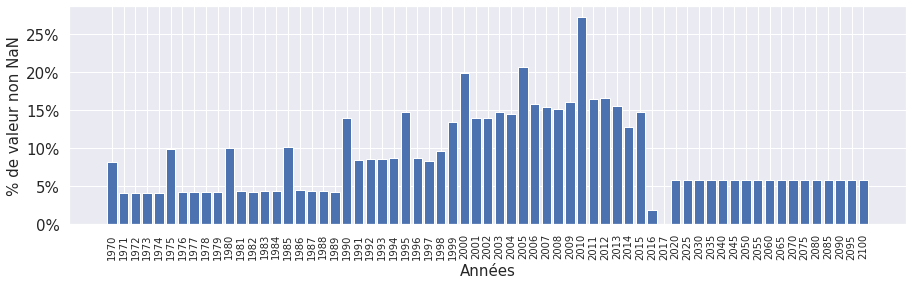

In [2]:
collumns_noNaN = EdStatsData.drop(columns=[
                                  "Country Name", "Country Code", "Indicator Name", "Indicator Code", "Unnamed: 69"])

xlabel = EdStatsData.columns[4:69]
fig = plt.figure(figsize=(15, 4))
plot = fig.add_subplot(1, 1, 1)
plt.bar(xlabel, 100*collumns_noNaN.count()/886930.)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=15)


fmt = '%.0f%%'  # Format you want the ticks, e.g. '40%'
xxticks = mtick.FormatStrFormatter(fmt)

# yaxis

plot.yaxis.set_major_formatter(xxticks)

plt.xlabel("Années", fontsize=15)
plt.ylabel("% de valeur non NaN", fontsize=15)


plt.show()

In [3]:
# on supprime les colonnes en dehors de l'interval [2000 - 2015] dans "dataFilterYear"

dataFilterYear=EdStatsData.drop(EdStatsData.loc[:, '1970':'1999'].columns, axis = 1) 
dataFilterYear=dataFilterYear.drop(dataFilterYear.loc[:, '2016':'Unnamed: 69'].columns, axis = 1)

# on créé la colonne "Count" dans "dataFilterYear" qui indique le nbr de NaN pour chaque ligne

dataFilterYearCount = dataFilterYear.drop(dataFilterYear.iloc[:, 0:4].columns, axis = 1) 
dataFilterYear["Count"] = dataFilterYearCount.count(axis=1)/16*100


# Filtre par couple pays/indicateur

In [4]:
# on fixe la valeur en % de la proportion de valeurs non NaN par indicateur

FILTRE_nonNaN = 50

def filtre(count):
    if count <= FILTRE_nonNaN:
#         print(' - "{}" n\'est pas un indicateur valide, nous le supprimons.' \
#             .format(indicator))
        return np.NaN
    return count


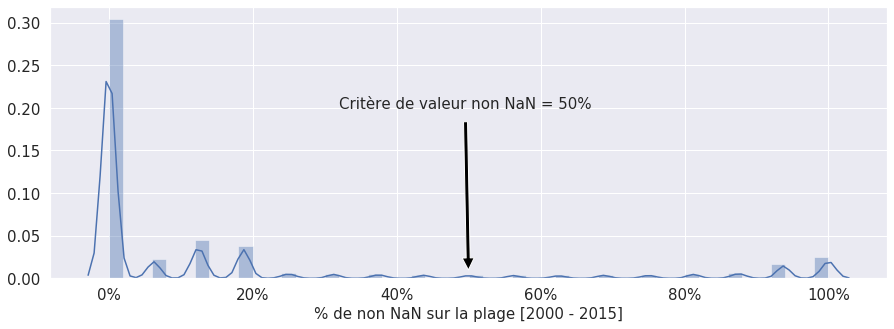

In [5]:
# on plot la distribution des lignes suivant leur taux de valeurs exploitables sur la plage [2000 - 2015] "

fig = plt.figure(figsize=(15,5))
plot = fig.add_subplot(1,1,1)
sns.distplot(dataFilterYear["Count"], kde=True);

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title("distribution des pays suivant leur taux de valeurs exploitables sur la plage [2000 - 2015] ",fontsize=15)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xxticks = mtick.FormatStrFormatter(fmt)

plt.annotate('Critère de valeur non NaN = 50%', xy=(50,0), xytext=(32,0.2), fontsize=15,
arrowprops={'facecolor':'black', 'shrink':0.05} )

# yaxis

# plot.yaxis.set_major_formatter(xxticks)
plot.xaxis.set_major_formatter(xxticks)

plt.xlabel("% de non NaN sur la plage [2000 - 2015]", fontsize=15)


plt.show()

In [6]:
print("Nombre d'indicateurs restants : ", dataFilterYear['Indicator Name'].unique().size)
print("Nombre de pays restants : ", dataFilterYear['Country Name'].unique().size)
print("Taille total du jeu de données :", dataFilterYear.size)

Nombre d'indicateurs restants :  3665
Nombre de pays restants :  242
Taille total du jeu de données : 18625530


In [7]:
# on peut filtrer enfin lignes par lignes celles dont la valeurs de NaN est inférieur à 50% \
# sans tomber sur l'ensemble vide
dataFilter = dataFilterYear.copy()
dataFilter["Count"] = dataFilterYear["Count"].apply(lambda x : filtre(x) )
dataFilter = dataFilter.dropna(subset=["Count"])

# Filtre par chaines de caractère

In [8]:
# on définit la fonction pour tester si une chaine de caractere est présente dans une autre

def testSring(strATester, strTest):
    if isinstance(strATester, str) :
        if (strATester.lower().find(strTest.lower()) >= 0) :
            return np.NaN
        return strATester
    else:
        return strATester



In [9]:
dataFilter["Indicator Name"] = dataFilter["Indicator Name"].apply(lambda x: testSring(x,"primary"))
dataFilter["Indicator Name"] = dataFilter["Indicator Name"].apply(lambda x: testSring(x,"lower secondary"))

dataFilter = dataFilter.dropna(subset=["Indicator Name"])

In [10]:
#     age\s(\d{1,2})|ages (\d*)-(\d*)
# , age\s\d{1,2}|, ages (\d*-\d*)

def NoneToZero(null_variable, siInt):
    if null_variable is None:
        return 0
    else:
        if siInt :
            return int(null_variable)
        else:
            return null_variable

def testSringRegex(strATester, regex, condition):
    m = re.search(regex, strATester)    
    if isinstance(strATester, str) == False : return strATester
    if m : 
        if NoneToZero(m.group(1), False) == condition :
#             print("condition", strATester)
            return strATester
        else:
#             print("NaN", strATester)
            return np.NaN
    else:
#         print("non m", strATester)
        return strATester
    

In [11]:
dataFilter["Indicator Name"]= dataFilter["Indicator Name"].apply([lambda x: testSringRegex(x, ", age\s\d{1,2}|, ages (\d*-\d*)", "15-24")])
dataFilter = dataFilter.dropna(subset=["Indicator Name"])


In [12]:
for string_test in ["male", "gender", "at market prices", "PPP", "GDP", "GNI", "Mortality rate", \
                    "Official entrance age", "Under-age", "Education programmes", "in private institutions", \
                    "Percentage of students in upper secondary education enrolled in", "vocational", "general",\
                    "Graduates", "private", "public", "per 100,000", "mobility", "mobility", "post-secondary",\
                    "in secondary ", "Net enrolment rate", "basic", "intermediate", "of the official age",\
                    "chool life expectancy", "Theoretical duration", "Total outbound international", "Gross",\
                    "Teacher", "Prevalence", "entrance age", "of compulsory", "Duration", \
                    "All staff compensation", "expenditure", "Health", "Welfare", "Agriculture",\
                    "Engineering", "Humanities", "unspecified fields", "childhood", "Science", "Services", \
                    "Social", "Pupil-teacher", "age 25+", "illiterate", "25+", "Out-of-school", "ISCED", \
                    "mobile", "25-64", "65+", "youth", "literacy", "Pupil/trained","Adjusted net", "teachers" ]:
    dataFilter = dataFilter[~dataFilter["Indicator Name"].str.contains(
        string_test)]

dataFilter["Indicator Name"].unique().size

10

# Séparation des jeux de données : [Groupes de pays] et [Pays]

In [13]:
# dataFilter[["Indicator Name"]]

In [14]:
for data in dataFilter["Indicator Name"].unique() : print(data)

Enrolment in tertiary education, all programmes, both sexes (number)
Enrolment in upper secondary education, both sexes (number)
Internet users (per 100 people)
Labor force, total
Population growth (annual %)
Population, total
Unemployment, total (% of total labor force)
Labor force with advanced education (% of total)
Population, ages 15-24, total
Personal computers (per 100 people)


In [15]:
# -----------------------------------------------------
# On modifie l'indicateur Unemployement en Employment pour que ce soit la plus grande valeur
# qui indique le meilleur indicateur 
# -----------------------------------------------------


# print(dataFilter.loc[dataFilter["Indicator Name"] ==  "Unemployment, total (% of total labor force)"  , '2000':'2015'])
dataFilter.loc[dataFilter["Indicator Name"] ==  "Unemployment, total (% of total labor force)"  , '2000':'2015'] = \
100 - dataFilter.loc[dataFilter["Indicator Name"] ==  "Unemployment, total (% of total labor force)"  , '2000':'2015']

dataFilter.loc[dataFilter["Indicator Name"] ==  \
                        "Unemployment, total (% of total labor force)"  , "Indicator Name"] = \
                        "Employment, total (% of total labor force)"

dataFilter.loc[dataFilter["Indicator Code"] ==  \
                        "SL.UEM.TOTL.ZS"  , "Indicator Code"] = \
                        "SL.EM.TOTL.ZS"
# print(dataFilter.loc[dataFilter["Indicator Name"] ==  "Employment, total (% of total labor force)"  , '2000':'2015'])




In [16]:
# -----------------------------------------------------------
# On trie les pays en 2 groupes : les ensembles de pays en "dataGroupCountry" et les pays uniques en "dataCountry"
# -----------------------------------------------------------


SerieGroupCountry = dataFilter['Country Name'].unique()[0:24]
# print(SerieGroupCountry)
# On supprime l'ensemble de pays "world" car il n'est pas pertinent
listG = SerieGroupCountry.tolist()
listG.remove('Heavily indebted poor countries (HIPC)')
listG.remove('High income')
listG.remove('Low & middle income')
listG.remove('Low income')
listG.remove('Middle income')
listG.remove('Lower middle income')
listG.remove('Upper middle income')

SerieGroupCountry = np.array(listG)


print(SerieGroupCountry)

# print(SerieGroupCountry)

SerieCountry= dataFilter['Country Name'].unique()[25:]



dataGroupCountry = dataFilter.loc[dataFilter['Country Name'].isin(SerieGroupCountry)].drop(columns={"Count"})
dataCountry = dataFilter.loc[dataFilter['Country Name'].isin(SerieCountry)].drop(columns={"Count"})

['Arab World' 'East Asia & Pacific'
 'East Asia & Pacific (excluding high income)' 'Euro area'
 'Europe & Central Asia' 'Europe & Central Asia (excluding high income)'
 'European Union' 'Latin America & Caribbean'
 'Latin America & Caribbean (excluding high income)'
 'Least developed countries: UN classification'
 'Middle East & North Africa'
 'Middle East & North Africa (excluding high income)' 'North America'
 'OECD members' 'South Asia' 'Sub-Saharan Africa'
 'Sub-Saharan Africa (excluding high income)']


In [17]:
# -----------------------------------------------------------
# Les 2 groupes de pays n'ont pas les mêmes indicateurs
# -----------------------------------------------------------


In [18]:
dataGroupCountry["Indicator Name"].unique()

array(['Enrolment in tertiary education, all programmes, both sexes (number)',
       'Enrolment in upper secondary education, both sexes (number)',
       'Internet users (per 100 people)', 'Labor force, total',
       'Population growth (annual %)', 'Population, total',
       'Employment, total (% of total labor force)',
       'Labor force with advanced education (% of total)'], dtype=object)

In [19]:
dataCountry["Indicator Name"].unique()

array(['Enrolment in upper secondary education, both sexes (number)',
       'Internet users (per 100 people)', 'Labor force, total',
       'Population growth (annual %)', 'Population, ages 15-24, total',
       'Population, total', 'Employment, total (% of total labor force)',
       'Enrolment in tertiary education, all programmes, both sexes (number)',
       'Personal computers (per 100 people)',
       'Labor force with advanced education (% of total)'], dtype=object)

In [20]:
dataCountry["Indicator Name"].unique()

array(['Enrolment in upper secondary education, both sexes (number)',
       'Internet users (per 100 people)', 'Labor force, total',
       'Population growth (annual %)', 'Population, ages 15-24, total',
       'Population, total', 'Employment, total (% of total labor force)',
       'Enrolment in tertiary education, all programmes, both sexes (number)',
       'Personal computers (per 100 people)',
       'Labor force with advanced education (% of total)'], dtype=object)

# Méthode de la moyenne sur [2000 - 2015]

In [21]:
# étude sur dataGroupCountry

dataGroupCountryIndicMean = dataGroupCountry.copy()
dataGroupCountryIndicMean["Mean"] = dataGroupCountryIndicMean.mean(
    axis=1, skipna=True, level=None, numeric_only=True)
dataGroupCountryIndicMean = dataGroupCountryIndicMean.drop(columns=[
                                                           "Country Code"])
dataGroupCountryIndicMean = dataGroupCountryIndicMean.drop(
    dataGroupCountryIndicMean.loc[:, "2000":"2015"].columns, axis=1)

# étude sur dataCountry
dataCountryIndicMean = dataCountry.copy()
dataCountryIndicMean["Mean"] = dataCountryIndicMean.mean(
    axis=1, skipna=True, level=None, numeric_only=True)
dataCountryIndicMean = dataCountryIndicMean.drop(columns=["Country Code"])
dataCountryIndicMean = dataCountryIndicMean.drop(
    dataCountryIndicMean.loc[:, "2000":"2015"].columns, axis=1)

In [22]:
# -----------------------------------------------------------
# Créations d'un dataframe avec en ligne les pays et en colonne les indicateurs 
# les valeurs sont les moyennes sur 2000 - 2015
# -----------------------------------------------------------

In [23]:
# étude sur dataGroupCountry

dataGroupCountryIndicMean.index = dataGroupCountryIndicMean["Indicator Name"].values
countryTab = dataGroupCountryIndicMean["Country Name"].unique()
dataGroupCountryIndicScatter = pd.DataFrame(np.nan, index=dataGroupCountryIndicMean["Country Name"].unique(
), columns=dataGroupCountryIndicMean["Indicator Name"].unique())
k = 0
for indic in dataGroupCountryIndicMean["Indicator Name"].unique():
    CountryTab = dataGroupCountryIndicMean.loc[dataGroupCountryIndicMean["Indicator Name"].unique()[
        k]]["Country Name"]
    for idx, country in enumerate(CountryTab):
        dataGroupCountryIndicScatter[indic][country] = dataGroupCountryIndicMean.loc[
            dataGroupCountryIndicMean["Indicator Name"].unique()
            [k]]["Mean"].values[idx]
    k = k+1


# étude sur dataCountry

dataCountryIndicMean.index = dataCountryIndicMean["Indicator Name"].values
countryTab = dataCountryIndicMean["Country Name"].unique()
dataCountryIndicScatter = pd.DataFrame(np.nan, index=dataCountryIndicMean["Country Name"].unique(
), columns=dataCountryIndicMean["Indicator Name"].unique())
k = 0
for indic in dataCountryIndicMean["Indicator Name"].unique():
    CountryTab = dataCountryIndicMean.loc[dataCountryIndicMean["Indicator Name"].unique()[
        k]]["Country Name"]
    for idx, country in enumerate(CountryTab):
        dataCountryIndicScatter[indic][country] = dataCountryIndicMean.loc[
            dataCountryIndicMean["Indicator Name"].unique()
            [k]]["Mean"].values[idx]
    k = k+1

In [24]:
# étude sur dataGroupCountry

colNamedataGroupCountry = dataGroupCountry["Indicator Name"].unique()
colCodedataGroupCountry = dataGroupCountry["Indicator Code"].unique()

# étude sur dataCountry

colNamedataCountry = dataCountry["Indicator Name"].unique()
colCodedataCountry = dataCountry["Indicator Code"].unique()

In [25]:
# étude sur dataGroupCountry

dataGroupCountryIndicScatter["Country Name"] = dataGroupCountry["Country Name"].unique(
)
dataGroupCountryIndicScatter = dataGroupCountryIndicScatter.rename(columns={colNamedataGroupCountry[0]: colCodedataGroupCountry[0],
                                                                            colNamedataGroupCountry[1]: colCodedataGroupCountry[1],
                                                                            colNamedataGroupCountry[2]: colCodedataGroupCountry[2],
                                                                            colNamedataGroupCountry[3]: colCodedataGroupCountry[3],
                                                                            colNamedataGroupCountry[4]: colCodedataGroupCountry[4],
                                                                            colNamedataGroupCountry[5]: colCodedataGroupCountry[5],
                                                                            colNamedataGroupCountry[6]: colCodedataGroupCountry[6],
                                                                            colNamedataGroupCountry[7]: colCodedataGroupCountry[7]}
                                                                   )
print("colCodedataGroupCountry", colCodedataGroupCountry)
colNamedataGroupCountry = dataGroupCountry["Indicator Name"].unique()
colCodedataGroupCountry = dataGroupCountry["Indicator Code"].unique()

# étude sur dataCountry


dataCountryIndicScatter["Country Name"] = dataCountry["Country Name"].unique()
dataCountryIndicScatter = dataCountryIndicScatter.rename(columns={colNamedataCountry[0]: colCodedataCountry[0],
                                                                  colNamedataCountry[1]: colCodedataCountry[1],
                                                                  colNamedataCountry[2]: colCodedataCountry[2],
                                                                  colNamedataCountry[3]: colCodedataCountry[3],
                                                                  colNamedataCountry[4]: colCodedataCountry[4],
                                                                  colNamedataCountry[5]: colCodedataCountry[5],
                                                                  colNamedataCountry[6]: colCodedataCountry[6],
                                                                  colNamedataCountry[7]: colCodedataCountry[7],
                                                                  colNamedataCountry[8]: colCodedataCountry[8],
                                                                  colNamedataCountry[9]: colCodedataCountry[9]},
                                                         )


print("colCodedataCountry", colCodedataCountry)
colNamedataCountry = dataCountry["Indicator Name"].unique()
colCodedataCountry = dataCountry["Indicator Code"].unique()

colCodedataGroupCountry ['SE.TER.ENRL' 'UIS.E.3' 'IT.NET.USER.P2' 'SL.TLF.TOTL.IN' 'SP.POP.GROW'
 'SP.POP.TOTL' 'SL.EM.TOTL.ZS' 'SL.TLF.ADVN.ZS']
colCodedataCountry ['UIS.E.3' 'IT.NET.USER.P2' 'SL.TLF.TOTL.IN' 'SP.POP.GROW'
 'SP.POP.1524.TO.UN' 'SP.POP.TOTL' 'SL.EM.TOTL.ZS' 'SE.TER.ENRL'
 'IT.CMP.PCMP.P2' 'SL.TLF.ADVN.ZS']


In [26]:
# étude sur dataGroupCountry

d = {"Indicator Name": colNamedataGroupCountry, "Indicator Code": colCodedataGroupCountry}
indicNamedataGroup = pd.DataFrame(data=d)

# étude sur dataCountry
d = {"Indicator Name": colNamedataCountry, "Indicator Code": colCodedataCountry}
indicNamedata = pd.DataFrame(data=d)


## scatter plot dataGroupCountry

'Enrolment in tertiary education, all programmes, both sexes (number)' : 
 ou en abrégé 'SE.TER.ENRL' 
 avec 'Enrolment in upper secondary education, both sexes (number)' 
 ou en abrégé 'UIS.E.3' 



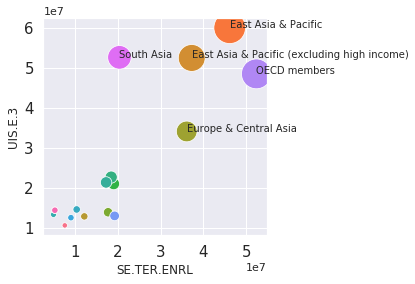

In [27]:
# étude sur dataGroupCountry




fig = plt.figure(figsize=(4,4))
plot = fig.add_subplot(1,1,1)
x=dataGroupCountryIndicScatter[indicNamedataGroup["Indicator Code"][0]]
y=dataGroupCountryIndicScatter[indicNamedataGroup["Indicator Code"][1]]
z=dataGroupCountryIndicScatter["Country Name"]


norm = x**2 + y**2
norm = norm.dropna()
norm5 = norm.nlargest(5).index


sns.scatterplot(x,y,hue=z, s=1000*norm/max(norm)).get_legend().remove()\
# .legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

# plt.tick_params(labelsize=7)

# plt.rc('xtick', labelsize=20)     
# plt.rc('ytick', labelsize=20)

print("'{}' : \n ou en abrégé '{}' \n avec '{}' \n ou en abrégé '{}' \n" \
            .format(indicNamedataGroup["Indicator Name"][0],indicNamedataGroup["Indicator Code"][0],\
                    indicNamedataGroup["Indicator Name"][1],indicNamedataGroup["Indicator Code"][1])
)



for idx, pays in enumerate(z):
#     print(idx,pays)
    if pays in norm5 : plt.annotate(pays, (x[idx], y[idx]))
# plt.title(titre,fontsize=15)
plt.show()

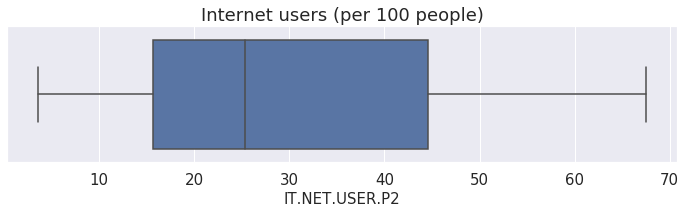

In [28]:
# on plot la distribution des lignes suivant leur taux de valeurs exploitables sur la plage [2000 - 2015] "

# x = dataGroupCountryIndicScatter[indicNamedata["Indicator Code"][0]]

fig = plt.figure(figsize=(12,2.5))
fig.subplots_adjust(hspace=2)

idx = 2
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
ax = sns.boxplot(x=dataGroupCountryIndicScatter[indicNamedataGroup["Indicator Code"][idx]])
plot.set_title(indicNamedataGroup["Indicator Name"][idx],fontsize=18)
plt.xticks(fontsize=15)
plt.xlabel(indicNamedataGroup["Indicator Code"][idx], fontsize=15)



plt.show()

## scatter plot dataCountry

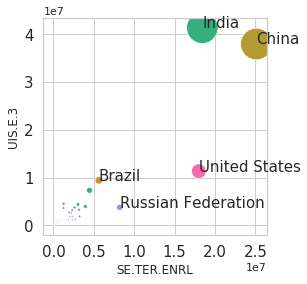

In [29]:
# étude sur dataCountry

# on plot la distribution des lignes suivant leur taux de valeurs exploitables sur la plage [2000 - 2015] "
fig = plt.figure(figsize=(4,4))
plot = fig.add_subplot(1,1,1)

codeX = indicNamedata["Indicator Code"][7]
codeY = indicNamedata["Indicator Code"][0]
nameX = indicNamedata["Indicator Name"][7]
nameY = indicNamedata["Indicator Name"][0]
x=dataCountryIndicScatter[codeX]
y=dataCountryIndicScatter[codeY]
z=dataCountryIndicScatter["Country Name"]

norm = x**2 + y**2
norm = norm.dropna()


norm5 = norm.nlargest(5).index


sns.scatterplot(x,y,hue=z, s=1000*norm/max(norm)).get_legend().remove()\
# .legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

# plt.tick_params(labelsize=7)

# plt.rc('xtick', labelsize=20)     
# plt.rc('ytick', labelsize=20)

# print( "Scatter plot des moyennes sur la plage [2000-2015] \n \n '{}' : \n ou en abrégé '{}' \n avec '{}' \n ou en abrégé '{}' \n" \
#             .format(nameX,codeX,nameY,codeY)
# )


for idx, pays in enumerate(z):
#     print(idx,pays)
    if pays in norm5 : plt.annotate(pays, (x[idx], y[idx]), fontsize=15)
# plt.title(titre,fontsize=15)
plt.show()

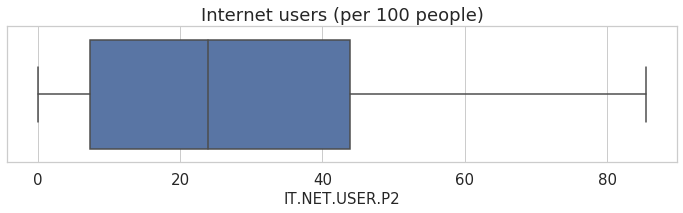

In [30]:
# on plot la distribution des lignes suivant leur taux de valeurs exploitables sur la plage [2000 - 2015] "

# x = dataCountryIndicScatter[indicNamedata["Indicator Code"][0]]

fig = plt.figure(figsize=(12,2.5))
fig.subplots_adjust(hspace=2)

idx = 1
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
ax = sns.boxplot(x=dataCountryIndicScatter[indicNamedata["Indicator Code"][idx]])
plot.set_title(indicNamedata["Indicator Name"][idx],fontsize=18)
plt.xticks(fontsize=15)
plt.xlabel(indicNamedata["Indicator Code"][idx], fontsize=15)



plt.show()

# Méthode par imputation

In [31]:
#    
# APPROCHE PAR IMPUTATION
#    

In [32]:

serie = dataGroupCountry.drop(columns=['Country Name',   'Country Code', 'Indicator Name', \
                                          'Indicator Code']).T
serie["indexColumns"] = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
serie.set_index("indexColumns", inplace=True)
for colonnes in serie.columns : 
    serie[colonnes] = serie[colonnes].interpolate(method='spline', order= 1 )
serieTranspose=serie.T
for colonne in dataGroupCountry.columns : 
    if str.isdigit(colonne) : 
        if int(colonne) in serieTranspose.columns : 
            dataGroupCountry.loc[:,[colonne]] = serieTranspose[int(colonne)]
            

/home/ious/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [33]:
serie = dataCountry.drop(columns=['Country Name',   'Country Code', 'Indicator Name', \
                                          'Indicator Code']).T
serie["indexColumns"] = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
serie.set_index("indexColumns", inplace=True)
for colonnes in serie.columns : 
    serie[colonnes] = serie[colonnes].interpolate(method='spline', order= 1 )
serieTranspose=serie.T
for colonne in dataCountry.columns : 
    if str.isdigit(colonne) : 
        if int(colonne) in serieTranspose.columns : 
            dataCountry.loc[:,[colonne]] = serieTranspose[int(colonne)]

In [34]:
dataGroupCountryIndicMax = dataGroupCountry.groupby('Indicator Name').max()
dataGroupCountryIndicMax = dataGroupCountryIndicMax.max(axis=1, skipna=True, level=None, numeric_only=True)

dataCountryIndicMax = dataCountry.groupby('Indicator Name').max()
dataCountryIndicMax = dataCountryIndicMax.max(axis=1, skipna=True, level=None, numeric_only=True)

In [35]:
dataGroupCountryNorm = dataGroupCountry.copy()
for idx, maxI in enumerate(dataGroupCountryIndicMax):
    dloc = dataGroupCountry.loc[dataGroupCountry["Indicator Name"] == dataGroupCountryIndicMax.index[idx]]
    dloc.loc[:, "2000":"2015"] = dloc.loc[:, "2000":"2015"]/maxI
    dataGroupCountryNorm.loc[dataGroupCountryNorm["Indicator Name"] == dataGroupCountryIndicMax.index[idx]] = \
    dloc.loc[dloc["Indicator Name"] == dataGroupCountryIndicMax.index[idx]]

dataCountryNorm = dataCountry.copy()
for idx, maxI in enumerate(dataCountryIndicMax):
    dloc = dataCountry.loc[dataCountry["Indicator Name"] == dataCountryIndicMax.index[idx]]
    dloc.loc[:, "2000":"2015"] = dloc.loc[:, "2000":"2015"]/maxI
    dataCountryNorm.loc[dataCountryNorm["Indicator Name"] == dataCountryIndicMax.index[idx]] = \
    dloc.loc[dloc["Indicator Name"] == dataCountryIndicMax.index[idx]]

/home/ious/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
for idx, indic in enumerate(dataGroupCountryNorm["Indicator Name"].unique()) : 
    print(idx,indic)

0 Enrolment in tertiary education, all programmes, both sexes (number)
1 Enrolment in upper secondary education, both sexes (number)
2 Internet users (per 100 people)
3 Labor force, total
4 Population growth (annual %)
5 Population, total
6 Employment, total (% of total labor force)
7 Labor force with advanced education (% of total)


In [37]:
indicNamedataGroup["weight"]=[5,5,10,1,1,1,1,5]
# indicNamedataGroup["weight"]=[1,1,1,1,1,1,1,1]
somme = np.sum(indicNamedataGroup["weight"])
indicNamedataGroup["weight"] = indicNamedataGroup["weight"]/somme


In [38]:

print(indicNamedataGroup.to_latex())

\begin{tabular}{lllr}
\toprule
{} &                                     Indicator Name &  Indicator Code &    weight \\
\midrule
0 &  Enrolment in tertiary education, all programme... &     SE.TER.ENRL &  0.172414 \\
1 &  Enrolment in upper secondary education, both s... &         UIS.E.3 &  0.172414 \\
2 &                    Internet users (per 100 people) &  IT.NET.USER.P2 &  0.344828 \\
3 &                                 Labor force, total &  SL.TLF.TOTL.IN &  0.034483 \\
4 &                       Population growth (annual \%) &     SP.POP.GROW &  0.034483 \\
5 &                                  Population, total &     SP.POP.TOTL &  0.034483 \\
6 &         Employment, total (\% of total labor force) &   SL.EM.TOTL.ZS &  0.034483 \\
7 &   Labor force with advanced education (\% of total) &  SL.TLF.ADVN.ZS &  0.172414 \\
\bottomrule
\end{tabular}



In [39]:
for idx, indic in enumerate(dataCountryNorm["Indicator Name"].unique()) : 
    print(idx,indic)

0 Enrolment in upper secondary education, both sexes (number)
1 Internet users (per 100 people)
2 Labor force, total
3 Population growth (annual %)
4 Population, ages 15-24, total
5 Population, total
6 Employment, total (% of total labor force)
7 Enrolment in tertiary education, all programmes, both sexes (number)
8 Personal computers (per 100 people)
9 Labor force with advanced education (% of total)


In [40]:
indicNamedata["weight"]=[5,10,1,1,2.5,1,1,5,2.5,5]
# indicNamedata["weight"]=[1,1,1,1,1,1,1,1,1,1]

somme = np.sum(indicNamedata["weight"])
indicNamedata["weight"] = indicNamedata["weight"]/somme

In [41]:
print(indicNamedata.to_latex())

\begin{tabular}{lllr}
\toprule
{} &                                     Indicator Name &     Indicator Code &    weight \\
\midrule
0 &  Enrolment in upper secondary education, both s... &            UIS.E.3 &  0.147059 \\
1 &                    Internet users (per 100 people) &     IT.NET.USER.P2 &  0.294118 \\
2 &                                 Labor force, total &     SL.TLF.TOTL.IN &  0.029412 \\
3 &                       Population growth (annual \%) &        SP.POP.GROW &  0.029412 \\
4 &                      Population, ages 15-24, total &  SP.POP.1524.TO.UN &  0.073529 \\
5 &                                  Population, total &        SP.POP.TOTL &  0.029412 \\
6 &         Employment, total (\% of total labor force) &      SL.EM.TOTL.ZS &  0.029412 \\
7 &  Enrolment in tertiary education, all programme... &        SE.TER.ENRL &  0.147059 \\
8 &                Personal computers (per 100 people) &     IT.CMP.PCMP.P2 &  0.073529 \\
9 &   Labor force with advanced education (\% o

In [42]:
dataGroupCountryPond = dataGroupCountryNorm.copy()
for idx, indic in enumerate(indicNamedataGroup["Indicator Name"]) : 
    df = dataGroupCountryPond.loc[dataGroupCountryPond["Indicator Name"]==indic]\
    .drop(columns= {'Country Name','Country Code', 'Indicator Name','Indicator Code'} )
    df = df * indicNamedataGroup["weight"][idx]
    for colonne in dataGroupCountryPond.columns :
        if colonne in df.columns : 
            dataGroupCountryPond.loc[dataGroupCountryPond["Indicator Name"]==indic,colonne] = df[colonne]
dataGroupCountryFinal = dataGroupCountryPond.groupby('Country Name').sum()
dataGroupCountryFinalBest = pd.DataFrame()
for colonne in dataGroupCountryFinal.columns : 
    df = pd.DataFrame()
    df["Moyenne pondérée des indices"]=dataGroupCountryFinal[colonne].nlargest(3).values
    df["Meilleur ensemble de pays"]=dataGroupCountryFinal[colonne].nlargest(3).index
    df["Années"]=[int(colonne), int(colonne),int(colonne)]
    dataGroupCountryFinalBest = dataGroupCountryFinalBest.append(df)

In [43]:
dataCountryPond = dataCountryNorm.copy()
for idx, indic in enumerate(indicNamedata["Indicator Name"]) : 
    df = dataCountryPond.loc[dataCountryPond["Indicator Name"]==indic]\
    .drop(columns= {'Country Name','Country Code', 'Indicator Name','Indicator Code'} )
    df = df * indicNamedata["weight"][idx]
    for colonne in dataCountryPond.columns :
        if colonne in df.columns : 
            dataCountryPond.loc[dataCountryPond["Indicator Name"]==indic,colonne] = df[colonne]
dataCountryFinal = dataCountryPond.groupby('Country Name').sum()
dataCountryFinalBest = pd.DataFrame()
for colonne in dataCountryFinal.columns : 
    df = pd.DataFrame()
    df["Moyenne pondérée des indices"]=dataCountryFinal[colonne].nlargest(3).values
    df["Meilleur ensemble de pays"]=dataCountryFinal[colonne].nlargest(3).index
    df["Années"]=[int(colonne), int(colonne),int(colonne)]
    dataCountryFinalBest = dataCountryFinalBest.append(df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

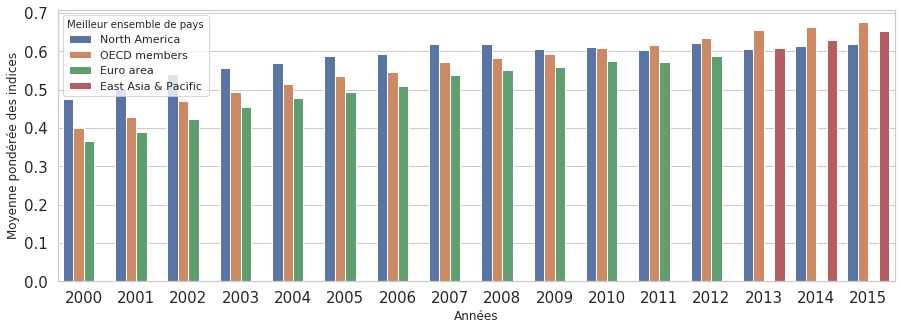

In [44]:
fig = plt.figure(figsize=(15,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
data = dataGroupCountryFinalBest
ax = sns.barplot(x="Années", y="Moyenne pondérée des indices", hue="Meilleur ensemble de pays", data=data)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

CPU times: user 294 ms, sys: 165 µs, total: 294 ms
Wall time: 292 ms


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

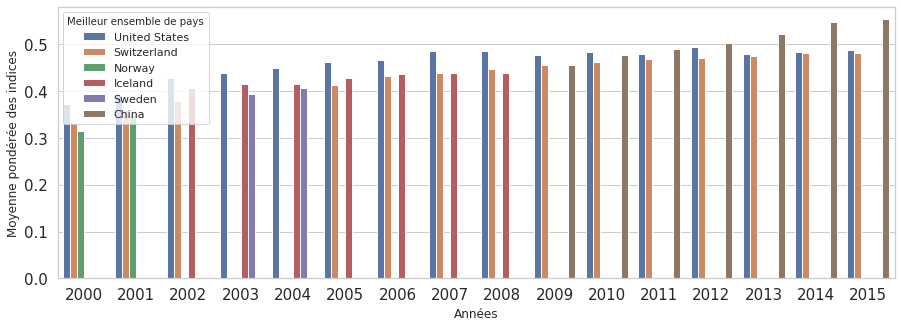

In [45]:
%%time
fig = plt.figure(figsize=(15,5))
plot = fig.add_subplot(1,1,1)
sns.set(style="whitegrid")
data = dataCountryFinalBest
ax = sns.barplot(x="Années", y="Moyenne pondérée des indices", hue="Meilleur ensemble de pays", data=data)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)